In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GroupKFold, StratifiedGroupKFold
import shap
import gpplot as gpp
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from rs3.seq import predict_seq
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import warnings
from core import tssbin_binary
from lightgbm import LGBMRegressor, plot_importance
from core1 import (setup_plots,
                  lollipop_plot,
                  get_feature_df,
                  summary_legacy,
                  dependence_legacy)
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings("ignore", category=UserWarning)
#optuna.logging.set_verbosity(optuna.logging.WARNING)


Todo
- DHS
- each nuetitde as a single nts only
- gilbert et al: top 5 features, look at easy feature


In [2]:
#Function
def obs_vals_vs_scores(dataset, list_obs_vals, list_scores, author='Gilbert', obs_meteric = 'Gamma'):
    for obs_v, score in zip(list_obs_vals, list_scores):
            plt.subplots(figsize=(4,4))
            gpp.point_densityplot(data=dataset[[score, obs_v]].dropna(),
                                     y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                   y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                    y=score, x=obs_v, method='spearman', loc='lower right')
           # plt.xlabel(x_axis_name)
            plt.title(author+" Crispri")
            plt.xlabel(obs_meteric)
           
            sns.despine()
            gpp.savefig('../figure/rs2/'+ score +'_vs_'+obs_meteric+'_'+author+'.pdf', dpi=300)
def tss_plot(dataset, y_axis, dataname='gilbert'):
    x_orders = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                            '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                             '+225 to +250','>+250']
    fig, axs = plt.subplots(nrows=len(y_axis),figsize=(7,6))
    for i in range(len(y_axis)):
        ax = sns.boxplot(data=dataset, x="tss_bins", y=y_axis[i], 
                   order = x_orders, color = 'grey', ax = axs[i])
        if i != len(y_axis)-1:
            ax.set(xticklabels=[])  
            ax.set(xlabel=None)
            ax.tick_params(bottom=False)
        else:
            ax.set(xlabel='TSS Bins')
            plt.xticks(rotation=90)
    
    gpp.savefig('../figure/rs2/'+ dataname +'_tss_box_plot.pdf', dpi=300)
def corr_pval_table(dataset, metric):
    tss_bins_cat = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                        '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                         '+225 to +250','>+250']
    data_performance = pd.DataFrame()
    for bins in tss_bins_cat:
        bin_sub = dataset[dataset['tss_bins'] == bins]
        corr_rs3, p_corr_rs3 = stats.spearmanr(bin_sub['Chen On-Target Efficacy Score'], bin_sub[str('avg_' + metric)])
        #corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['reverse ' + metric])
        corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['avg_' + metric])

        data_performance = data_performance.append({'bin':bins,
                                          'corr_rs3': corr_rs3, 
                                          'p_val_corr_rs3': p_corr_rs3,
                                          'corr_seq_target': corr_target,
                                         'p_val_corr_seq_target': p_corr_target}, ignore_index=True)
    return data_performance

# Train model

In [3]:

# list_seq = gilbert2014_rs3['sgRNA Context Sequence'].tolist()
# ofile = open('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/gilbert_2014/RS2_score/gilbert_rs2.txt', "w")

# for i in range(len(list_seq)):

#     ofile.write(">" + str(i) + "\n" +list_seq[i] + "\n")

# #do not forget to close it

# ofile.close()


In [4]:
rs2 = pd.read_table('../data/gilbert_2014/RS2_score/2d91dbbe-sgrna-designs.txt')
rs2 = rs2[['sgRNA Context Sequence', 'On-Target Efficacy Score']]
rs2.columns = ['sgRNA Context Sequence', 'RS2 On-Target Efficacy Score']

### Import Gilbert to train 

In [5]:
gilbert2014_rs3 = pd.read_csv('../data/gilbert_2014/gilbert2014_activity.csv')
gilbert2014_rs3 = pd.merge(gilbert2014_rs3, rs2, on = 'sgRNA Context Sequence')
gilbert2014_rs3 = gilbert2014_rs3.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
gilbert2014_rs3 = gilbert2014_rs3[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'RS2 On-Target Efficacy Score','Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_gamma', 'avg_mean_centered_neg_gamma']]
gilbert2014_rs3 = tssbin_binary(gilbert2014_rs3)

<AxesSubplot:xlabel='RS2 On-Target Efficacy Score', ylabel='Chen On-Target Efficacy Score'>

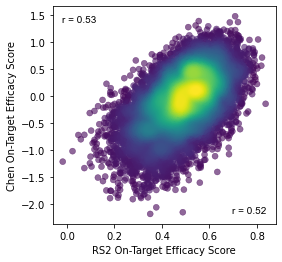

In [6]:
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=gilbert2014_rs3,
                                     y='Chen On-Target Efficacy Score', x='RS2 On-Target Efficacy Score')
gpp.add_correlation(data=gilbert2014_rs3,
                                   y='Chen On-Target Efficacy Score', x='RS2 On-Target Efficacy Score')
gpp.add_correlation(data=gilbert2014_rs3,
                                    y='Chen On-Target Efficacy Score', x='RS2 On-Target Efficacy Score', method='spearman', loc='lower right')


In [7]:
tss_bins_col_name = [col for col in gilbert2014_rs3.columns if col.startswith('tss_bins_')]
x_variable = ['sgRNA \'Cut\' Site TSS Offset', 'sgRNA Context Sequence','RS2 On-Target Efficacy Score'] + tss_bins_col_name

### Define X and Y and group in gilbert 

In [8]:
X = gilbert2014_rs3[x_variable]
X = X.set_index('sgRNA Context Sequence')    
y = gilbert2014_rs3['avg_gamma'] * -1
grps = gilbert2014_rs3['Target Gene Symbol']


### Define objective to train the model on Gilbert

In [9]:
def objective(trial, X, y, groups, cv=4 ):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01,0.02,0.03,0.04, 0.05]),
        "num_leaves": trial.suggest_int('num_leaves', 8, 256),
        "min_child_samples": trial.suggest_int('min_child_samples', 50, 256)

    }

    cv_scores = np.zeros(cv)
    
    #gkf_cv = GroupKFold(n_splits=3)
    gkf_cv = StratifiedGroupKFold(n_splits=cv, shuffle=True, random_state=1)
    df_group = pd.DataFrame()


    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X,[1]*grps, groups=groups)):
        X_train, X_test, y_train, y_test = X.iloc[ix_train], X.iloc[ix_test], y.iloc[ix_train], y.iloc[ix_test]

        model = LGBMRegressor(random_state=7, n_jobs=1, **param_grid)
        df_group = df_group.append({'fold': split, 'num_train_gene': len(set(grps[ix_train].tolist())),
                    'num_train_sgrna': len(grps[ix_train].tolist()), 
                    'num_test_gene': len(set(grps[ix_test].tolist())),
                   'num_test_sgRNA': len(grps[ix_test].tolist()),
                   'num_overlap_gene': len(list(set(grps[ix_train]) & set(grps[ix_test])))}, ignore_index=True)
        print(df_group)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            verbose=-1,
             early_stopping_rounds=50,)
        preds = model.score(X_train, y_train)
        
        cv_scores[split] = preds


    return 1-np.mean(cv_scores)

In [10]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")

def func(trial):
    return objective(trial, X, y, grps)

study.optimize(func, n_trials=50);

[I 2022-11-10 03:16:38,203] A new study created in memory with name: LGBM Regressor


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 0.0121015
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0126566
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:16:39,442] Trial 0 finished with value: 0.869217700587951 and parameters: {'n_estimators': 758, 'learning_rate': 0.05, 'num_leaves': 21, 'min_child_samples': 217}. Best is trial 0 with value: 0.869217700587951.


Early stopping, best iteration is:
[74]	valid_0's l2: 0.0129503
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 0.0120985
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 0.0126694
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:16:40,719] Trial 1 finished with value: 0.8673742444593563 and parameters: {'n_estimators': 636, 'learning_rate': 0.02, 'num_leaves': 256, 'min_child_samples': 172}. Best is trial 1 with value: 0.8673742444593563.


Early stopping, best iteration is:
[140]	valid_0's l2: 0.0129476
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's l2: 0.0121087
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 0.0126677
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:16:42,042] Trial 2 finished with value: 0.869723822131693 and parameters: {'n_estimators': 405, 'learning_rate': 0.02, 'num_leaves': 223, 'min_child_samples': 222}. Best is trial 1 with value: 0.8673742444593563.


Early stopping, best iteration is:
[170]	valid_0's l2: 0.0129597
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 0.0120546
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0126318
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:16:42,899] Trial 3 finished with value: 0.8730700128310215 and parameters: {'n_estimators': 355, 'learning_rate': 0.05, 'num_leaves': 8, 'min_child_samples': 114}. Best is trial 1 with value: 0.8673742444593563.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's l2: 0.01293
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 0.0129085
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early sto

[I 2022-11-10 03:16:44,537] Trial 4 finished with value: 0.8516770364816602 and parameters: {'n_estimators': 851, 'learning_rate': 0.02, 'num_leaves': 200, 'min_child_samples': 92}. Best is trial 4 with value: 0.8516770364816602.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0121666
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0127293
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:16:46,102] Trial 5 finished with value: 0.8493885151118334 and parameters: {'n_estimators': 858, 'learning_rate': 0.02, 'num_leaves': 194, 'min_child_samples': 79}. Best is trial 5 with value: 0.8493885151118334.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's l2: 0.0121042
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[180]	valid_0's l2: 0.0126622
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:16:48,046] Trial 6 finished with value: 0.8686374558535239 and parameters: {'n_estimators': 360, 'learning_rate': 0.01, 'num_leaves': 60, 'min_child_samples': 221}. Best is trial 5 with value: 0.8493885151118334.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 0.0121242
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 0.012689
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 03:16:49,324] Trial 7 finished with value: 0.8535648536093399 and parameters: {'n_estimators': 1226, 'learning_rate': 0.03, 'num_leaves': 118, 'min_child_samples': 100}. Best is trial 5 with value: 0.8493885151118334.


Early stopping, best iteration is:
[60]	valid_0's l2: 0.0129857
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0121201
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0126648
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:16:50,472] Trial 8 finished with value: 0.865527632053802 and parameters: {'n_estimators': 589, 'learning_rate': 0.05, 'num_leaves': 124, 'min_child_samples': 180}. Best is trial 5 with value: 0.8493885151118334.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l2: 0.0129571
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 0.0121174
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:16:51,677] Trial 9 finished with value: 0.8638475004830075 and parameters: {'n_estimators': 228, 'learning_rate': 0.03, 'num_leaves': 42, 'min_child_samples': 157}. Best is trial 5 with value: 0.8493885151118334.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 0.0122618
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l2: 0.0127742
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:16:52,824] Trial 10 finished with value: 0.8386883118950449 and parameters: {'n_estimators': 1138, 'learning_rate': 0.04, 'num_leaves': 171, 'min_child_samples': 54}. Best is trial 10 with value: 0.8386883118950449.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 0.0129836
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.0122664
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:16:53,983] Trial 11 finished with value: 0.8374977881017794 and parameters: {'n_estimators': 1132, 'learning_rate': 0.04, 'num_leaves': 175, 'min_child_samples': 53}. Best is trial 11 with value: 0.8374977881017794.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0130023
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.0122116
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:16:55,105] Trial 12 finished with value: 0.8435406158241175 and parameters: {'n_estimators': 1247, 'learning_rate': 0.04, 'num_leaves': 161, 'min_child_samples': 60}. Best is trial 11 with value: 0.8374977881017794.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0129809
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0122437
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:16:56,262] Trial 13 finished with value: 0.8395282408502591 and parameters: {'n_estimators': 1480, 'learning_rate': 0.04, 'num_leaves': 155, 'min_child_samples': 58}. Best is trial 11 with value: 0.8374977881017794.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0129835
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0121003
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:16:57,261] Trial 14 finished with value: 0.8612767822824662 and parameters: {'n_estimators': 1150, 'learning_rate': 0.04, 'num_leaves': 86, 'min_child_samples': 126}. Best is trial 11 with value: 0.8374977881017794.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0129406
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0122732
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:16:58,495] Trial 15 finished with value: 0.8427330966008968 and parameters: {'n_estimators': 1045, 'learning_rate': 0.04, 'num_leaves': 166, 'min_child_samples': 57}. Best is trial 11 with value: 0.8374977881017794.


Early stopping, best iteration is:
[36]	valid_0's l2: 0.0130141
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l2: 0.0121241
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0126612
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:16:59,548] Trial 16 finished with value: 0.8707306625541431 and parameters: {'n_estimators': 1432, 'learning_rate': 0.04, 'num_leaves': 102, 'min_child_samples': 255}. Best is trial 11 with value: 0.8374977881017794.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0129553
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's l2: 0.0120764
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:17:01,702] Trial 17 finished with value: 0.8607868957558352 and parameters: {'n_estimators': 1030, 'learning_rate': 0.01, 'num_leaves': 193, 'min_child_samples': 143}. Best is trial 11 with value: 0.8374977881017794.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 0.012163
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0127314
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 03:17:02,805] Trial 18 finished with value: 0.8507398614857049 and parameters: {'n_estimators': 991, 'learning_rate': 0.04, 'num_leaves': 233, 'min_child_samples': 82}. Best is trial 11 with value: 0.8374977881017794.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 0.0129663
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l2: 0.0122648
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:04,045] Trial 19 finished with value: 0.8364573780107731 and parameters: {'n_estimators': 1337, 'learning_rate': 0.04, 'num_leaves': 146, 'min_child_samples': 51}. Best is trial 19 with value: 0.8364573780107731.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's l2: 0.0120949
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.012701
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 03:17:05,146] Trial 20 finished with value: 0.8605080995478798 and parameters: {'n_estimators': 1343, 'learning_rate': 0.04, 'num_leaves': 144, 'min_child_samples': 125}. Best is trial 19 with value: 0.8364573780107731.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0129454
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 0.0122679
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:06,289] Trial 21 finished with value: 0.8364010852871355 and parameters: {'n_estimators': 1329, 'learning_rate': 0.04, 'num_leaves': 179, 'min_child_samples': 52}. Best is trial 21 with value: 0.8364010852871355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0129885
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0121808
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:07,418] Trial 22 finished with value: 0.8441334922488051 and parameters: {'n_estimators': 1337, 'learning_rate': 0.04, 'num_leaves': 135, 'min_child_samples': 71}. Best is trial 21 with value: 0.8364010852871355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0129727
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's l2: 0.0121385
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:08,545] Trial 23 finished with value: 0.8517184577060012 and parameters: {'n_estimators': 1324, 'learning_rate': 0.04, 'num_leaves': 182, 'min_child_samples': 100}. Best is trial 21 with value: 0.8364010852871355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 0.0129841
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0121783
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:09,654] Trial 24 finished with value: 0.8466153507265801 and parameters: {'n_estimators': 1446, 'learning_rate': 0.04, 'num_leaves': 219, 'min_child_samples': 75}. Best is trial 21 with value: 0.8364010852871355.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0129673
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0122687
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:10,851] Trial 25 finished with value: 0.8360566818031017 and parameters: {'n_estimators': 1189, 'learning_rate': 0.03, 'num_leaves': 101, 'min_child_samples': 53}. Best is trial 25 with value: 0.8360566818031017.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0129786
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0121425
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:12,005] Trial 26 finished with value: 0.850760665521347 and parameters: {'n_estimators': 1254, 'learning_rate': 0.03, 'num_leaves': 79, 'min_child_samples': 88}. Best is trial 25 with value: 0.8360566818031017.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.0129506
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 0.0121176
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:13,223] Trial 27 finished with value: 0.8557084768272067 and parameters: {'n_estimators': 958, 'learning_rate': 0.03, 'num_leaves': 109, 'min_child_samples': 110}. Best is trial 25 with value: 0.8360566818031017.


Early stopping, best iteration is:
[78]	valid_0's l2: 0.0129709
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 0.0121952
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.012732
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:17:14,491] Trial 28 finished with value: 0.8406065966673953 and parameters: {'n_estimators': 1339, 'learning_rate': 0.03, 'num_leaves': 90, 'min_child_samples': 66}. Best is trial 25 with value: 0.8360566818031017.


Early stopping, best iteration is:
[54]	valid_0's l2: 0.0129855
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's l2: 0.0121031
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's l2: 0.0126726
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:17:16,409] Trial 29 finished with value: 0.8681580979074861 and parameters: {'n_estimators': 1492, 'learning_rate': 0.01, 'num_leaves': 146, 'min_child_samples': 194}. Best is trial 25 with value: 0.8360566818031017.


Early stopping, best iteration is:
[292]	valid_0's l2: 0.0129562
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0120868
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 0.0127078
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:17:17,402] Trial 30 finished with value: 0.8629105355634934 and parameters: {'n_estimators': 740, 'learning_rate': 0.05, 'num_leaves': 62, 'min_child_samples': 139}. Best is trial 25 with value: 0.8360566818031017.


Early stopping, best iteration is:
[43]	valid_0's l2: 0.0129608
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0122845
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0127873
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:17:18,708] Trial 31 finished with value: 0.8366344380720789 and parameters: {'n_estimators': 1212, 'learning_rate': 0.03, 'num_leaves': 137, 'min_child_samples': 51}. Best is trial 25 with value: 0.8360566818031017.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0129802
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0121931
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:19,983] Trial 32 finished with value: 0.8451449289690129 and parameters: {'n_estimators': 1182, 'learning_rate': 0.03, 'num_leaves': 132, 'min_child_samples': 70}. Best is trial 25 with value: 0.8360566818031017.


Early stopping, best iteration is:
[59]	valid_0's l2: 0.0129757
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0122781
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l2: 0.012783
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:17:21,238] Trial 33 finished with value: 0.834183917684716 and parameters: {'n_estimators': 1382, 'learning_rate': 0.03, 'num_leaves': 108, 'min_child_samples': 50}. Best is trial 33 with value: 0.834183917684716.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.013007
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0122088
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0127463
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:17:22,512] Trial 34 finished with value: 0.8426151309778664 and parameters: {'n_estimators': 1414, 'learning_rate': 0.03, 'num_leaves': 106, 'min_child_samples': 67}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0121428
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0127146
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:17:23,634] Trial 35 finished with value: 0.8539499588895202 and parameters: {'n_estimators': 1375, 'learning_rate': 0.03, 'num_leaves': 64, 'min_child_samples': 91}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0129516
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0121466
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:17:25,069] Trial 36 finished with value: 0.8503890632639852 and parameters: {'n_estimators': 1067, 'learning_rate': 0.02, 'num_leaves': 118, 'min_child_samples': 83}. Best is trial 33 with value: 0.834183917684716.


Early stopping, best iteration is:
[84]	valid_0's l2: 0.0129568
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0121978
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 0.0127172
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:17:26,179] Trial 37 finished with value: 0.8419983734388067 and parameters: {'n_estimators': 1306, 'learning_rate': 0.05, 'num_leaves': 43, 'min_child_samples': 50}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0129403
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 0.0121327
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:27,764] Trial 38 finished with value: 0.8550219421565193 and parameters: {'n_estimators': 940, 'learning_rate': 0.02, 'num_leaves': 250, 'min_child_samples': 100}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0121901
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 0.0127436
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:17:29,050] Trial 39 finished with value: 0.8462736920518668 and parameters: {'n_estimators': 1275, 'learning_rate': 0.03, 'num_leaves': 205, 'min_child_samples': 75}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's l2: 0.0129634
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	valid_0's l2: 0.0121029
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 03:17:31,342] Trial 40 finished with value: 0.8665282592138811 and parameters: {'n_estimators': 645, 'learning_rate': 0.01, 'num_leaves': 97, 'min_child_samples': 207}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 0.0121959
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0127364
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:17:32,807] Trial 41 finished with value: 0.8400483920410589 and parameters: {'n_estimators': 1194, 'learning_rate': 0.03, 'num_leaves': 142, 'min_child_samples': 63}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0122845
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0127873
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:17:34,490] Trial 42 finished with value: 0.8366344380720789 and parameters: {'n_estimators': 1401, 'learning_rate': 0.03, 'num_leaves': 125, 'min_child_samples': 51}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0122088
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0127463
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:17:35,990] Trial 43 finished with value: 0.8426151309778664 and parameters: {'n_estimators': 1098, 'learning_rate': 0.03, 'num_leaves': 184, 'min_child_samples': 67}. Best is trial 33 with value: 0.834183917684716.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.0121561
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0127227
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:17:37,358] Trial 44 finished with value: 0.8475200933886265 and parameters: {'n_estimators': 1266, 'learning_rate': 0.03, 'num_leaves': 154, 'min_child_samples': 78}. Best is trial 33 with value: 0.834183917684716.


Early stopping, best iteration is:
[57]	valid_0's l2: 0.0129668
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0122771
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0127826
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:17:38,741] Trial 45 finished with value: 0.8337280828742252 and parameters: {'n_estimators': 1396, 'learning_rate': 0.03, 'num_leaves': 120, 'min_child_samples': 50}. Best is trial 45 with value: 0.8337280828742252.


Early stopping, best iteration is:
[55]	valid_0's l2: 0.0130031
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 0.0122593
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 0.0127463
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:17:40,059] Trial 46 finished with value: 0.8354643903935807 and parameters: {'n_estimators': 1393, 'learning_rate': 0.05, 'num_leaves': 121, 'min_child_samples': 58}. Best is trial 45 with value: 0.8337280828742252.


Early stopping, best iteration is:
[42]	valid_0's l2: 0.0129807
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 0.0121048
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0126788
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:17:41,337] Trial 47 finished with value: 0.8644344060831775 and parameters: {'n_estimators': 1500, 'learning_rate': 0.05, 'num_leaves': 115, 'min_child_samples': 168}. Best is trial 45 with value: 0.8337280828742252.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 0.0129426
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 0.0122235
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:42,506] Trial 48 finished with value: 0.8430273474442488 and parameters: {'n_estimators': 1413, 'learning_rate': 0.05, 'num_leaves': 81, 'min_child_samples': 59}. Best is trial 45 with value: 0.8337280828742252.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0129696
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l2: 0.0121432
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 03:17:43,724] Trial 49 finished with value: 0.8531446927103354 and parameters: {'n_estimators': 428, 'learning_rate': 0.05, 'num_leaves': 95, 'min_child_samples': 99}. Best is trial 45 with value: 0.8337280828742252.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0129684


In [11]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.83373
	Best params:
		n_estimators: 1396
		learning_rate: 0.03
		num_leaves: 120
		min_child_samples: 50


In [12]:
model = LGBMRegressor( **study.best_params)
model.fit(X, y)

LGBMRegressor(learning_rate=0.03, min_child_samples=50, n_estimators=1396,
              num_leaves=120)

In [13]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)
# explainer_model = shap.Explainer(model)
shap_values_model = explainer(X)
#gpp.savefig('../figure/shapval_model_seq_tss_v2.pdf', dpi=300)

In [14]:
shap_values_model

.values =
array([[-3.48035371e-02,  2.00285411e-02,  8.64441742e-05, ...,
         3.32097505e-05,  0.00000000e+00,  0.00000000e+00],
       [-1.92731769e-02, -1.46325977e-02, -1.84448071e-03, ...,
         9.00986572e-04,  0.00000000e+00,  0.00000000e+00],
       [ 6.22132275e-02, -1.84604298e-02,  1.72863634e-04, ...,
         3.66013281e-04,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.07134778e-02, -1.09206169e-03,  1.75151545e-04, ...,
        -8.15559214e-04,  0.00000000e+00,  0.00000000e+00],
       [ 2.80373512e-02, -5.76448215e-02,  9.19555149e-05, ...,
         2.15891569e-03,  0.00000000e+00,  0.00000000e+00],
       [ 1.76834976e-02, -2.83182827e-02,  3.75504693e-04, ...,
        -7.50518339e-04,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([0.07112287, 0.07112287, 0.07112287, ..., 0.07112287, 0.07112287,
       0.07112287])

.data =
array([[281.    ,   0.8   ,   0.    , ...,   0.    ,   0.    ,   1.    ],
       [121.    ,   0.4829,   1.    , ...,

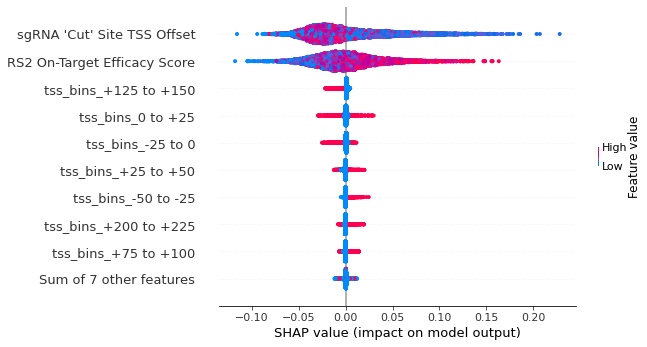

In [15]:
shap.plots.beeswarm(shap_values_model)


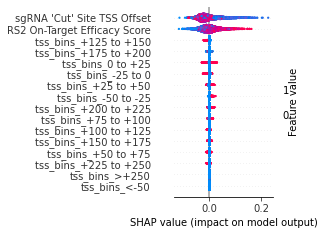

In [16]:
summary_legacy(shap_values_model, X, show=False, plot_size=(2.2, 3.5),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=50)
gpp.savefig('../figure/rs2/shapval_model_seq_tss.pdf', dpi=300)

# Check the most optimal prediction using Gilbert

In [17]:
X_gilbert = X
y_gilbert = y

In [18]:
X_gilbert['Crispri Seq + Target Score'] = model.predict(X_gilbert)
X_gilbert.reset_index(inplace=True)

In [19]:
X_val_pre_y_gilbert = pd.merge(gilbert2014_rs3, X_gilbert, 
                               on = list(set(gilbert2014_rs3.columns) & set(X_gilbert.columns)))

In [20]:
#X_val_pre_y_gilbert['reverse gamma'] = X_val_pre_y_gilbert['avg_gamma']*-1

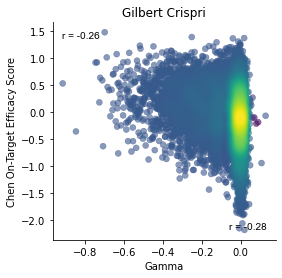

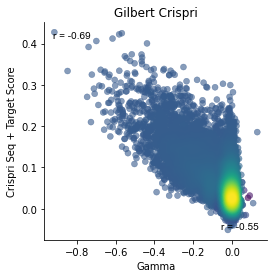

In [21]:
#obs_vals = [ 'avg_gamma', 'reverse gamma']
obs_vals = [ 'avg_gamma', 'avg_gamma']
scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_gilbert, obs_vals, scores, author='Gilbert', obs_meteric = 'Gamma')

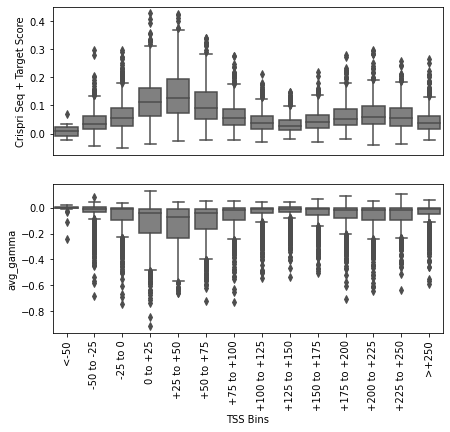

In [22]:
y_axis_gilbert = ["Crispri Seq + Target Score", 'avg_gamma']
tss_plot(X_val_pre_y_gilbert,y_axis_gilbert)

In [23]:
gilbert_performance = corr_pval_table(X_val_pre_y_gilbert, metric = 'gamma')

In [24]:
gilbert_performance

,bin,corr_rs3,p_val_corr_rs3,corr_seq_target,p_val_corr_seq_target
0,<-50,-0.356719,9.475101e-02,-0.481838,1.990399e-02
1,-50 to -25,-0.223628,8.775065e-10,-0.377479,2.635796e-26
2,-25 to 0,-0.236031,3.668072e-12,-0.489324,4.424713e-52
3,0 to +25,-0.268912,9.070488e-19,-0.599617,5.005501e-103
4,+25 to +50,-0.380375,4.365975e-32,-0.655749,9.369915e-111
5,+50 to +75,-0.377657,2.879616e-33,-0.618608,1.859001e-100
6,+75 to +100,-0.282004,1.275281e-16,-0.524107,1.120271e-59
7,+100 to +125,-0.252137,1.325435e-13,-0.446526,2.940467e-42
8,+125 to +150,-0.184255,6.874567e-08,-0.377372,5.453042e-30
9,+150 to +175,-0.255465,7.064837e-14,-0.502676,1.514987e-54


In [25]:
corr_gilbert = pd.melt(gilbert_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

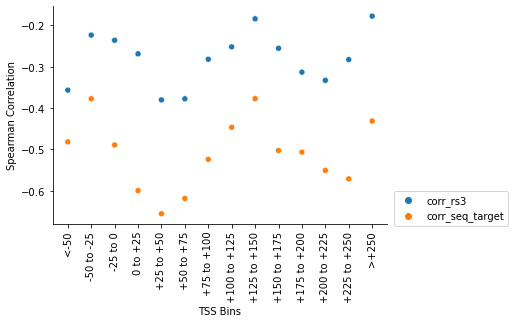

In [26]:
sns.scatterplot(data=corr_gilbert, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/rs2/gilbert_spearman_tss_box_plot.pdf', dpi=300)


# Test on Horlbeck 2016_sept

In [27]:
test_dataset_horlbeck = pd.read_csv('../data/horlbeck_2016_sept/horlbeck2016_sept_activity.csv')


In [28]:
test_dataset_horlbeck.head()

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,On-Target Efficacy Score,sgRNA 'Cut' Site TSS Offset,DHS Score,Off-Target Rank,Pick Order,avg_rank,avg_mean_centered_neg_lfc,avg_zscore_neg_lfc,avg_median_centered_neg_lfc,avg_robust_zscore_neg_lfc,avg_lfc
0,GAAAAGGCTGCCGCTCTGGG,GCGGGAAAAGGCTGCCGCTCTGGGAGGAGG,COPS3,-0.1170,0,1.0,50,25.0,0.75,0.033173,0.203717,0.037973,0.245310,-0.454623
1,GAAAATAGGGCGCCGGAAGT,GTGAGAAAATAGGGCGCCGGAAGTCGGCTT,C18orf21,0.1372,-10,1.0,5,24.0,1.00,0.026221,0.859323,0.018950,0.634685,-0.187906
2,GAAACCGCGGCGATACTGGG,TGTAGAAACCGCGGCGATACTGGGAGGAAG,WDR46,0.1774,229,1.0,43,10.0,1.00,0.075586,0.707107,0.075586,1.000000,-1.432060
3,GAAACCTTGGACACAGTTCT,TGAGGAAACCTTGGACACAGTTCTGGGTAC,NKAP,-0.1104,13,1.0,16,23.0,1.00,0.098937,0.707107,0.098937,1.000000,-1.306050
4,GAAACGCACAGCAACTCGCA,CAGAGAAACGCACAGCAACTCGCATGGAGG,DHX9,0.1515,23,1.0,16,4.0,1.00,0.042397,0.707107,0.042397,1.000000,-0.580343


In [29]:
list_seq = test_dataset_horlbeck['sgRNA Context Sequence'].tolist()
ofile = open('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/gilbert_2014/RS2_score/horlbeck_rs2.txt', "w")

for i in range(len(list_seq)):

    ofile.write(">" + str(i) + "\n" +list_seq[i] + "\n")

#do not forget to close it

ofile.close()

#### Add TSS bins binary

In [30]:

rs2_horlbeck = pd.read_table('../data/horlbeck_2016_sept/RS2_score/15e45768-sgrna-designs.txt')
rs2_horlbeck = rs2_horlbeck[['sgRNA Context Sequence', 'On-Target Efficacy Score']]
rs2_horlbeck.columns = ['sgRNA Context Sequence', 'RS2 On-Target Efficacy Score']

In [31]:
test_dataset_horlbeck = test_dataset_horlbeck.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_horlbeck = pd.merge(test_dataset_horlbeck, rs2_horlbeck, on = 'sgRNA Context Sequence')
test_dataset_horlbeck = test_dataset_horlbeck[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'RS2 On-Target Efficacy Score','Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_lfc']]
test_dataset_horlbeck = tssbin_binary(test_dataset_horlbeck)




#### Define X and Y 

In [32]:
test_dataset_horlbeck_X = test_dataset_horlbeck[x_variable]
test_dataset_horlbeck_X = test_dataset_horlbeck_X.set_index('sgRNA Context Sequence')    
y = test_dataset_horlbeck['avg_lfc'] *-1

#### Predicted

In [33]:
test_dataset_horlbeck_X['Crispri Seq + Target Score'] = model.predict(test_dataset_horlbeck_X)
test_dataset_horlbeck_X.reset_index(inplace=True)

In [34]:
X_val_pre_y_horlbeck = pd.merge(test_dataset_horlbeck, test_dataset_horlbeck_X, 
                       on = list(set(test_dataset_horlbeck.columns) & set(test_dataset_horlbeck_X.columns)))

In [35]:
#X_val_pre_y_horlbeck['reverse lfc'] = X_val_pre_y_horlbeck['avg_lfc']*-1

In [54]:
X_val_pre_y_horlbeck.columns

Index(['sgRNA Context Sequence', 'sgRNA Sequence', 'Target Gene Symbol',
       'RS2 On-Target Efficacy Score', 'Chen On-Target Efficacy Score',
       'sgRNA 'Cut' Site TSS Offset', 'avg_lfc', 'tss_bins',
       'tss_bins_+100 to +125', 'tss_bins_+125 to +150',
       'tss_bins_+150 to +175', 'tss_bins_+175 to +200',
       'tss_bins_+200 to +225', 'tss_bins_+225 to +250', 'tss_bins_+25 to +50',
       'tss_bins_+50 to +75', 'tss_bins_+75 to +100', 'tss_bins_-25 to 0',
       'tss_bins_-50 to -25', 'tss_bins_0 to +25', 'tss_bins_<-50',
       'tss_bins_>+250', 'Crispri Seq + Target Score'],
      dtype='object')

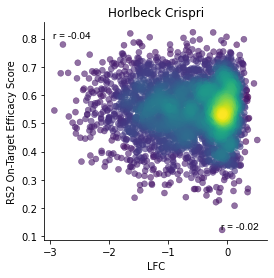

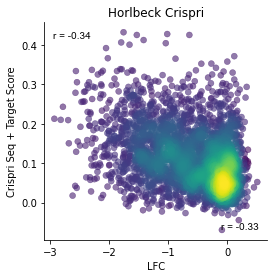

In [55]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['RS2 On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_horlbeck, obs_vals_h, scores, author='Horlbeck', obs_meteric = 'LFC')

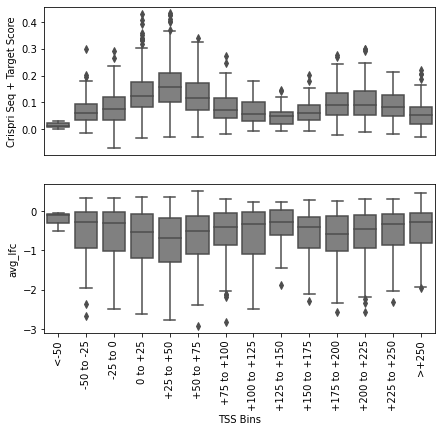

In [37]:
y_axis_horlbeck = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_horlbeck,y_axis_horlbeck, dataname='horlbeck')

In [38]:
horlbeck_performance = corr_pval_table(X_val_pre_y_horlbeck, metric = 'lfc')
corr_horlbeck = pd.melt(horlbeck_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

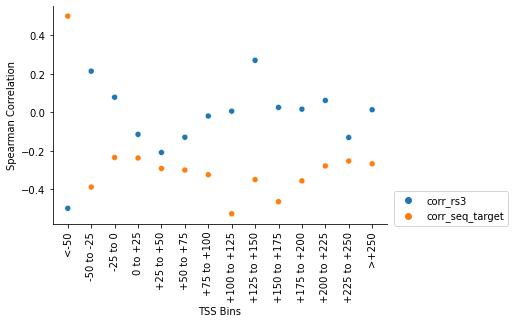

In [39]:
sns.scatterplot(data=corr_horlbeck, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/rs2/horlbeck_spearman_tss_box_plot.pdf', dpi=300)


# Sanson et al

In [40]:
test_dataset_sanson = pd.read_csv('../data/sanson_2018/sanson2018_activity.csv')


In [ ]:
list_seq = test_dataset_sanson['sgRNA Context Sequence'].tolist()
ofile = open('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/sanson_2018/RS2_score/sanson_rs2.txt', "w")

for i in range(len(list_seq)):

    ofile.write(">" + str(i) + "\n" +list_seq[i] + "\n")

#do not forget to close it

ofile.close()

In [41]:
rs2_sanson = pd.read_table('../data/sanson_2018/RS2_score/232b9234-sgrna-designs.txt')
rs2_sanson = rs2_sanson[['sgRNA Context Sequence', 'On-Target Efficacy Score']]
rs2_sanson.columns = ['sgRNA Context Sequence', 'RS2 On-Target Efficacy Score']

In [42]:
test_dataset_sanson = test_dataset_sanson.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_sanson = pd.merge(test_dataset_sanson, rs2_sanson, on = 'sgRNA Context Sequence')
test_dataset_sanson = test_dataset_sanson[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'RS2 On-Target Efficacy Score','Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_lfc']]
test_dataset_sanson = tssbin_binary(test_dataset_sanson)

In [43]:
sum(test_dataset_sanson['sgRNA \'Cut\' Site TSS Offset'] <= -50)

0

In [44]:
test_dataset_sanson['tss_bins_<-50'] = 0

In [45]:
test_dataset_sanson_X = test_dataset_sanson[x_variable]
test_dataset_sanson_X = test_dataset_sanson_X.set_index('sgRNA Context Sequence')    
y = test_dataset_sanson['avg_lfc']*-1

In [46]:
test_dataset_sanson_X['Crispri Seq + Target Score'] = model.predict(test_dataset_sanson_X)
test_dataset_sanson_X.reset_index(inplace=True)

In [47]:
X_val_pre_y_sanson = pd.merge(test_dataset_sanson, test_dataset_sanson_X, 
                              on = list(set(test_dataset_sanson.columns) & set(test_dataset_sanson_X.columns)))

In [48]:
#X_val_pre_y_sanson['reverse lfc'] = X_val_pre_y_sanson['avg_lfc']*-1

In [49]:
X_val_pre_y_sanson.groupby('Target Gene Symbol')[['avg_lfc','Crispri Seq + Target Score']].corr().unstack().iloc[:,1]


Target Gene Symbol
AAMP        0.982326
AARS1       0.229903
AARS2      -0.846045
AASDHPPT    0.937369
AATF       -0.641631
              ...   
ZNRD2       0.999809
ZPR1       -0.922200
ZRANB1      0.846365
ZWILCH     -0.764474
ZZZ3       -0.977876
Name: (avg_lfc, Crispri Seq + Target Score), Length: 1461, dtype: float64

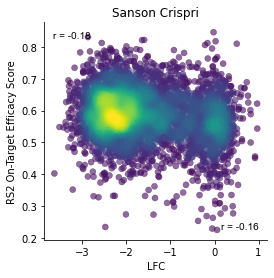

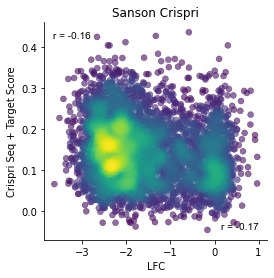

In [56]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['RS2 On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_sanson, obs_vals_h, scores, author='Sanson', obs_meteric = 'LFC')

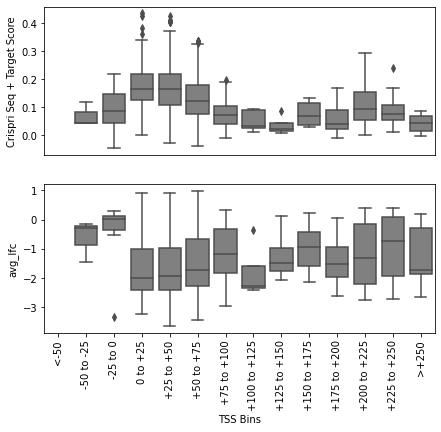

In [51]:
y_axis_sanson = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_sanson,y_axis_sanson, dataname = 'sanson')

In [52]:
sanson_performance = corr_pval_table(X_val_pre_y_sanson, metric = 'lfc')
corr_sanson = pd.melt(sanson_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

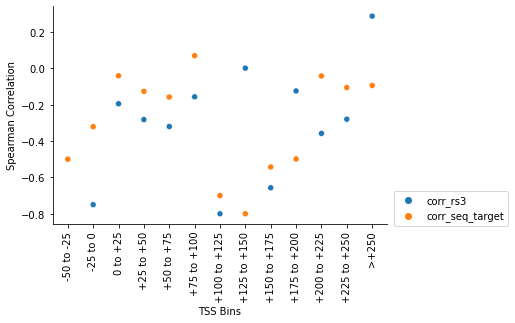

In [53]:
sns.scatterplot(data=corr_sanson, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/rs2/sanson_spearman_tss_box_plot.pdf', dpi=300)


In [ ]:
# anaysis

In [2]:
# gene_symbol = pd.DataFrame(X_val_pre_y_sanson['Target Gene Symbol'].value_counts()).reset_index()
# gene_symbol = gene_symbol[gene_symbol['Target Gene Symbol'] >= 3]
# gene_3 = X_val_pre_y_sanson[X_val_pre_y_sanson['Target Gene Symbol'].isin(gene_symbol['index'])]

In [ ]:
# gene_corr_rs3 = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Chen On-Target Efficacy Score']].corr(method = 'spearman').unstack()
# gene_corr_rs3.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
# gene_corr_rs3 = pd.DataFrame(gene_corr_rs3.iloc[:,1]).reset_index()

In [ ]:
# gene_corr_rs3_target = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
# gene_corr_rs3_target.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
# gene_corr_rs3_target = pd.DataFrame(gene_corr_rs3_target.iloc[:,1]).reset_index()

In [ ]:
# gene_corr_scores = gene_3.groupby('Target Gene Symbol')[['Chen On-Target Efficacy Score','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
# gene_corr_scores.columns = ['Correlation_Val1_Val1', 'Correlation_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
# gene_corr_scores = pd.DataFrame(gene_corr_scores.iloc[:,1]).reset_index()


In [ ]:
# gene_corr = pd.merge(pd.merge(gene_corr_rs3, gene_corr_rs3_target, on = 'Target Gene Symbol'), gene_corr_scores, on = 'Target Gene Symbol')

In [ ]:
# sns.scatterplot(data=gene_corr, x="Correlation_LFC_RS3", y="Correlation_LFC_RS3_target")
# plt.axvline(0, 0,2)
# plt.axhline(0, 0,2)

In [ ]:
# sns.boxplot(x=gene_corr["Correlation_RS3_target"] )

In [ ]:
# gene_corr[(gene_corr['Correlation_LFC_RS3'] < 0) & (gene_corr['Correlation_LFC_RS3_target']>0)]